In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, ConcatDataset
from torchvision import datasets, transforms, models
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import time

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)

In [ ]:
os.chdir("../..")
repo_root = Path.cwd()
print(repo_root)

/home/casio/Documents/cache


In [ ]:
from homeworks.homework3.hw3.corpus import(
    pushkin_poems,
    local_docs_code,
    get_texts
)
from homeworks.homework3.hw3.scripts.download_dataset import (
    iter_text_lines,
)
from homeworks.homework3.hw3.bpe.metrics import (
    get_metrics,
    get_tokens_per_word,
    get_unused_tokens,
)
from homeworks.homework3.hw3.bpe.tokenizer import BPETokenizer




/home/casio/Documents/cache/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
PUSHKIN = repo_root / "homeworks/homework3/dataverse_files/texts"
CORPUS_FILE = repo_root / "ru_corpus.txt"
LOCAL_DOCS_CODE = repo_root

from homeworks.homework3.hw3.scripts.train_tok import train_tok
TOK_PATH = repo_root / "homeworks/homework3/hw3/tokenizer_NOW.json"

CORPUS: [ZeroAgency ru-big-russian-dataset](https://huggingface.co/datasets/ZeroAgency/ru-big-russian-dataset)

In [ ]:
# WARN: DO NOT START THIS LINE IF YOU DON NOT WANT TO TRAIN 
# print("TRAINING STARTING", end="")
# for i in range(10):
#     print(".", end="")
#     time.sleep(5)
# print()

tok = train_tok(
    file_path = CORPUS_FILE,
    vocab_size = 5000,
    max_chars= int(4e6),
    output = repo_root / "homeworks/homework3/hw3/tokenizer.json",
    verbose = False,
)

os.rename(
    repo_root / "homeworks/homework3/hw3/tokenizer.json",
    TOK_PATH
)

In [ ]:


# docs = get_texts(
#     local_docs_code(LOCAL_DOCS_CODE),
#     max_chars=int(2e6),
# )
# pushkin = get_texts(pushkin_poems(PUSHKIN), max_chars=int(2e6))
# tok = BPETokenizer.load(TOK_PATH)

from homeworks.homework3.hw3.scripts.eval_tok import eval as eval_tok
def report():
    eval_tok(
        TOK_PATH,
        LOCAL_DOCS_CODE,
        PUSHKIN,
    )
    
    

report()



---docs + code---
tokens=33200 bytes=85163 chars=80000 words=10536
compress t/b:0.38984
compress t/c:0.41500
avg t/w:3.15110
---pushkin---
tokens=37864 bytes=142761 chars=80000 words=12936
compress t/b:0.26523
compress t/c:0.47330
avg t/w:2.92703

docs+code: avg tokens/w_top16%=1.67479, unique=1523, selected=244
pushkin: avg tokens/w_top16%=1.73930, unique=6099, selected=976
pushkin: unused token fraction=0.67994
docs+code: unused token fraction=0.66333


Видим: локальные .md и .py дают выше tokens/byte (char, word) => BPE использует больше токенов на единицу текста.
Пушкинские тексты: наоборот, соответствующие значения ниже => BPE эффективнее.

пушкинские текста требуют больше уникальных слов в топе.

Вывод: для пушинских текстов покрытие 

Compression Ratio & vocab size

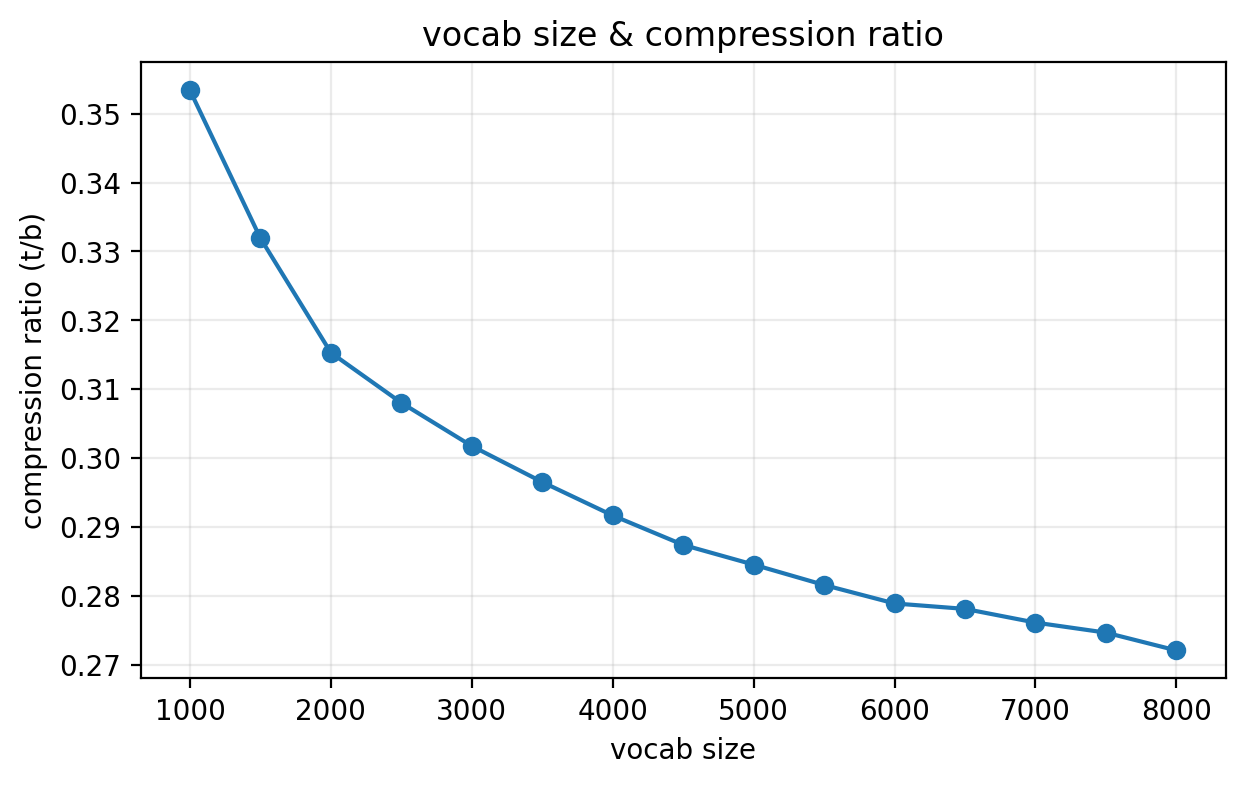

In [ ]:
from homeworks.homework3.hw3.scripts.rnn import train as train_rnn
from dataclasses import dataclass

@dataclass
class RNNConfig:
    tokenizer_path: Path = TOK_PATH
    corpus_path: Path = CORPUS_FILE
    max_chars: int = int(3e6)
    block_size: int = 128
    batch_size: int = 64
    lr: float = 1e-3
    epochs: int = 9
    device: str = "cuda"

# RNN: Other parameters:
# - embedding size: 256
# - hidden size: 512
# - num layers: 2
# - dropout: 0.15

# WARN: IT WAS TRAINED BEFORE. SO I DO NOT StART IT AGAIN HERE. IT WAS SAVED IN THE REPO AS rnn.pt
train_rnn(
    tok_path=RNNConfig.tokenizer_path,
    corpus_path=RNNConfig.corpus_path,
    max_chars=RNNConfig.max_chars,
    block_size=RNNConfig.block_size,
    batch_size=RNNConfig.batch_size,
    lr=RNNConfig.lr,
    epochs=RNNConfig.epochs,
    device=RNNConfig.device,
)

KeyboardInterrupt: 

In [ ]:
from homeworks.homework3.hw3.scripts.rnn import LMDataset, RNN, load_sequences, pack_batch
def eval_rnn(
    tok_path: Path,
    model_path: Path,
    corpus_path: Path,
    *,
    max_chars: int,
    block_size: int,
    batch_size: int,
    device: str,
) -> tuple[float, float]:
    tok = BPETokenizer.load(tok_path)
    seqs = load_sequences(
        tok,
        corpus_path,
        max_chars=max_chars,
        add_spec=True,
    )
    ds = LMDataset(seqs, block_size=block_size)
    loader = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=pack_batch,
        num_workers=0,
    )
    model = RNN(tok.vocab_size).to(device)
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    model.eval()

    criterion = nn.CrossEntropyLoss(ignore_index=0)
    total_loss = 0.0
    total_tokens = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device)
            y = y.to(device)
            logits = model(x) # [b,t,v]
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            total_loss += loss.item() * y.numel()
            total_tokens += y.numel()
            
            if i == 0:
                preds = logits.argmax(dim=-1).tolist() # [b,t]
                x = x.tolist()
                y = y.tolist()
                n_show = min(3, len(x))
                for i in range(n_show):
                    input = x[i]
                    target = y[i]
                    pred = preds[i]
                    lenght = sum(1 for tid in input if tid != 0)
                    print("example{i} length={lenght}")
                    print("decoded input :", tok.decode(input[:lenght], skip_spec=True))
                    print("decoded target:", tok.decode(target[:lenght], skip_spec=True))
                    print("decoded pred  :", tok.decode(pred[:lenght], skip_spec=True))

    if total_tokens == 0:
        return float("inf"), float("inf")
    avg_loss = total_loss / total_tokens
    ppl = torch.exp(torch.tensor(avg_loss)).item()
    return avg_loss, ppl

loss, ppl = eval_rnn(
    tok_path=Path("homeworks/homework3/hw3/tokenizer_NOW.json"),
    model_path=Path("homeworks/homework3/hw3/rnn.pt"),
    corpus_path=Path("ru_corpus.txt"),
    max_chars=500_000,
    block_size=128,
    batch_size=32,
    device="cpu",
)
print(f"eval loss={loss:.4f} ppl={ppl:.4f}")

/tmp/ipykernel_11155/434255229.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path, map_location=device)


example{i} length={lenght}
decoded input : Распиши словами данные-Русский язык
decoded target: Распиши словами данные-Русский язык
decoded pred  : {'олож подробами:,подск язык,
example{i} length={lenght}
decoded input : Надежность либо взаимопомощь и простота в общении, товарищество-7 (28%)
decoded target: Надежность либо взаимопомощь и простота в общении, товарищество-7 (28%)
decoded pred  : {омежно:еч вопонощь. вое в земении. аогдаарищество,п%п00))\
example{i} length={lenght}
decoded input : Близость по духу либо по роду занятий-1 (4%)
decoded target: Близость по духу либо по роду занятий-1 (4%)
decoded pred  : {.огис\ имениухов иаб в мамств,ятий нап б20.)\
eval loss=4.0786 ppl=59.0645


#### Замена токенизатора GPT2

In [ ]:
from pathlib import Path
from datasets import Dataset
from transformers import (
    AutoModelForCausalLM,
    PreTrainedTokenizerFast,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
)
from tokenizers import Tokenizer, models, pre_tokenizers, decoders

from homeworks.homework3.hw3.bpe.tokenizer import BPETokenizer
from homeworks.homework3.hw3.corpus import get_texts
from homeworks.homework3.hw3.scripts.download_dataset import iter_text_lines

# config
TOKENIZER_JSON = Path("homeworks/homework3/hw3/tokenizer_NOW.json")
CORPUS_FILE = Path("ru_corpus.txt")
OUTPUT_DIR = Path("gpt2-ft")
MAX_CHARS = int(1e6)
BLOCK_SIZE = 256
TRAIN_BATCH = 8
EVAL_BATCH = 8
EPOCHS = 1
LR = 5e-5
WARMUP = 100
WEIGHT_DECAY = 0.01
LOG_STEPS = 100
GRAD_ACCUM = 2
TEST_SPLIT = 0.05


bp = BPETokenizer.load(TOKENIZER_JSON)
vocab = bp.vocab
merges = bp.bpe_model.merges
tok_obj = Tokenizer(models.BPE(vocab=vocab, merges=merges))
tok_obj.pre_tokenizer = pre_tokenizers.Whitespace()
tok_obj.decoder = decoders.BPEDecoder()
spec = bp.spec_token2id
tok_fast = PreTrainedTokenizerFast(
    tokenizer_object=tok_obj,
    bos_token="<bos>",
    eos_token="<eos>",
    unk_token="<unk>",
    pad_token="<pad>",
)

# load model + resize embeddings
model = AutoModelForCausalLM.from_pretrained("gpt2", device_map="cuda")
model.resize_token_embeddings(len(tok_fast))

# prepare dataset
texts = get_texts(
    iter_text_lines(
        CORPUS_FILE,
        encoding="utf-8",
        max_chars=MAX_CHARS,
    ),
    max_chars=MAX_CHARS,
)

ds = Dataset.from_dict({"text": texts})

def tok_fn(batch):
    return tok_fast(batch["text"], truncation=True, max_length=BLOCK_SIZE)

train_ds = ds["train"].map(tok_fn, batched=True, remove_columns=["text"], num_proc=2)

collator = DataCollatorForLanguageModeling(tokenizer=tok_fast, mlm=False)

# training config
kwargs = dict(
    output_dir=str(OUTPUT_DIR),
    per_device_train_batch_size=TRAIN_BATCH,
    per_device_eval_batch_size=EVAL_BATCH,
    num_train_epochs=EPOCHS,
    gradient_accumulation_steps=GRAD_ACCUM,
    logging_steps=LOG_STEPS,
    learning_rate=LR,
    warmup_steps=WARMUP,
    weight_decay=WEIGHT_DECAY,
    fp16=False,
    report_to=[],
)


training_args = TrainingArguments(**kwargs)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    data_collator=collator,
    tokenizer=tok_fast,
)

trainer.train()
trainer.save_model(str(OUTPUT_DIR))
tok_fast.save_pretrained(str(OUTPUT_DIR))

Map (num_proc=2): 100%|██████████| 718/718 [00:00<00:00, 4242.20 examples/s]
/tmp/ipykernel_11946/523201650.py:119: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 3, 'bos_token_id': 2, 'pad_token_id': 1}.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,6.149800
200,5.069600
300,4.970400
400,4.823200
500,4.766400
600,4.745000
700,4.691800
800,4.699100


('gpt2-ft/tokenizer_config.json',
 'gpt2-ft/special_tokens_map.json',
 'gpt2-ft/tokenizer.json')

In [ ]:
import json

MODEL_DIR = Path("gpt2-ft")
TOK_PATH = Path("homeworks/homework3/hw3/tokenizer_NOW.json")

bp = BPETokenizer.load(TOK_PATH)
print("vocab size (bp):", bp.vocab_size)
print("spec_token2id:", bp.spec_token2id)

model = AutoModelForCausalLM.from_pretrained(str(MODEL_DIR), local_files_only=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

ids = bp.encode("Привет, Мир!", add_spec=False)
input_tokens = [bp.id2token.get(i, f"<id:{i}>") for i in ids]
input_ids = torch.tensor([ids], device=device)
pad_id = bp.spec_token2id.get("<pad>", 0)
attn = (torch.tensor([ids], device=device) != pad_id).long()
with torch.no_grad():
    out = model.generate(
        input_ids=input_ids,
        attention_mask=attn,
        max_new_tokens=80,
        do_sample=True,
        temperature=0.9,
        top_k=50,
        top_p=0.95,
        pad_token_id=pad_id,
        eos_token_id=bp.spec_token2id.get("<eos>"),
        return_dict_in_generate=True,
        output_scores=True,
    )
out_ids = out.sequences[0].tolist()
dec = bp.decode(out_ids, skip_spec=True)
print(dec)

vocab size (bp): 5000
spec_token2id: {'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3}
Привет, Мир! дляка дляамов от:


#### Дообучение QWEN3-0.6B на анекдотах.

In [ ]:
# all code in sft.py.
# here we train only 1 epoch and 15 steps at all, because of time. For real I used 4 epochs.

from homeworks.homework3.jokes.sft import train as gpt2_tune, SFTArgs

gpt2_tune("Qwen/Qwen3-0.6B", dataset_path="homeworks/homework3/jokes/anecd.jsonl", sft_args=SFTArgs(num_train_epochs=1, output_dir="qwen3-0.6b-anecdote-1epoch", max_steps=15))


loading model...


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.
/home/casio/Documents/cache/venv/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/casio/Documents/cache/venv/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Now lets go generate jokes.

from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer

ft = "homeworks/homework3/jokes/qwen3-0.6b-anecdote"
model  = "Qwen/Qwen3-0.6B"

tok = AutoTokenizer.from_pretrained(model)

model = AutoModelForCausalLM.from_pretrained(
    model,
    device_map="auto",
    low_cpu_mem_usage=True,
    dtype=torch.float16,
)

model = PeftModel.from_pretrained(model, ft)
model.eval()

prompts = [
    'Продолжи смешно шутку: Есть только одна система:',
]

with torch.no_grad():
    for prompt in prompts:
        inputs = tok(prompt, return_tensors="pt").to(model.device)
        output = model.generate(
            **inputs,  
            max_new_tokens=200,       
            temperature=.5,
            top_p=.90,
            top_k=50,
            repetition_penalty=1.2,
            do_sample=True,
        )
        text = tok.decode(output[0], skip_special_tokens=True)
        print(text)
        print()
        

Продолжи смешно шутку: Есть только одна система: логин и пароль.

